## Import Modules

In [91]:
import os
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import numpy as np
import scipy as sp
import tifffile as tiff
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128             # to set a higher threshold for maximum .gif size that we can embed here
import os; import glob; import cv2
from scipy import ndimage, misc
from scipy.stats import chi2
from scipy.ndimage import maximum_filter, label, find_objects
from skimage.feature import peak_local_max
from natsort import natsorted
import scipy.io as sio
import skimage.io as io
import multiprocessing as mp
import trackpy as tp
import ipywidgets as widgets
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)     # ignore warnings for specific matplotlib commands which will be outdated soon
from IPython.display import display, Image


## Define functions
### Function for processing file paths in Windows

In [2]:
def convert_to_code_path(windows_path):
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")

### Clustering function

In [3]:
def cluster_optical_flow(us, vs, kernel_type='gaussian', kernel_size=21, normalize=False, verbose=False):    
    # create a gaussian kernel of size NxN
    N = kernel_size
    if kernel_type == 'gaussian':
        gaussian_window = sp.signal.windows.gaussian(N, std=5, sym=True)
        gaussian_window = gaussian_window.reshape(-1, 1)

        gaussian_kernel = gaussian_window @ gaussian_window.T
        gaussian_kernel[N // 2, N // 2] = 0  # Set the center value to 0
        kernel_gpu = cp.asarray(gaussian_kernel)  # Convert to CuPy array for GPU usage

    elif kernel_type == 'uniform':
        kernel_gpu = cp.ones((N, N), dtype=cp.float32)
        kernel_gpu[N // 2, N // 2] = 0
        kernel_gpu = kernel_gpu / cp.sum(kernel_gpu)

    # Convolve horizontal optical flow with the kernel
    cluster = []

    for u, v in tqdm(zip(us, vs), disable=(not verbose)):
        u_gpu = cp.asarray(u)
        v_gpu = cp.asarray(v)

        if normalize:
            norm = cp.sqrt(u_gpu**2 + v_gpu**2)
            norm[norm == 0] = 1.0  # Avoid division by zero
            u_gpu = u_gpu / norm
            v_gpu = v_gpu / norm
            u_gpu[cp.isnan(u_gpu)] = 0
            v_gpu[cp.isnan(v_gpu)] = 0

        # Perform convolution using CuPy's GPU-based convolution
        u_gpu = u_gpu * cpx_ndimage.convolve(u_gpu, kernel_gpu, mode='constant', cval=0.0)
        v_gpu = v_gpu * cpx_ndimage.convolve(v_gpu, kernel_gpu, mode='constant', cval=0.0)

        # Append the sum of the convolved u and v to the cluster
        cluster.append(u_gpu.get() + v_gpu.get())  # Move the result back to CPU memory

    return cluster

### Remove static and discontinuous tracks

In [4]:
def remove_static_tracks(df, movement_threshold=1.0):
    """
    Removes static tracks based on the total displacement of particles.
    
    Parameters:
    - df: pandas DataFrame, contains the particle tracking data with 'x', 'y', and 'particle' columns
    - movement_threshold: float, the minimum total displacement required for a track to be considered valid
    
    Returns:
    - filtered DataFrame containing only the tracks with total displacement greater than the movement threshold
    """
    valid_particles = []

    # Group by 'particle' to process each track separately
    for particle_id, track in df.groupby('particle'):
        # Get the x and y positions and compute the differences
        x_diff = track['x'].diff().dropna()
        y_diff = track['y'].diff().dropna()

        # Calculate the Euclidean distance (displacement) between consecutive points
        displacement = np.sqrt(x_diff**2 + y_diff**2)

        # Calculate the total displacement for this track
        total_displacement = displacement.sum()

        # If the total displacement is greater than the movement threshold, keep the track
        if total_displacement > movement_threshold:
            valid_particles.append(particle_id)

    # Filter the DataFrame to keep only valid particles
    return df[df['particle'].isin(valid_particles)]


def remove_discontinuous_tracks(df):
    # Create an empty list to store valid particles (those with no gaps)
    valid_particles = []

    # Group by 'particle' to process each track separately
    for particle_id, track in df.groupby('particle'):
        # Get the frames for the current track and sort them
        frames = track['frame'].sort_values()

        # Check if the difference between consecutive frames is exactly 1
        frame_diff = frames.diff().dropna()  # Calculate difference between successive frames
        if all(frame_diff == 1):  # If all differences are 1, no gaps
            valid_particles.append(particle_id)  # Keep this track

    # Filter the DataFrame to keep only valid particles
    return df[df['particle'].isin(valid_particles)]
    

# Combine the previous 2 functions to remove discontinuous and static tracks
def filter_tracks(df, movement_threshold=1.0):
    # Drop NaNs from the dataframe before processing
    df = df.dropna(subset=['x', 'y', 'frame'])
    
    df_no_gaps = remove_discontinuous_tracks(df)  # Remove tracks with gaps
    df_filtered = remove_static_tracks(df_no_gaps, movement_threshold)  # Remove static tracks
    
    return df_filtered

## Load the mask and Optical Flow results

In [133]:
# Address where all raw images are
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_02_11_C2_ridges_timelapse1');
file_name = 'ridges_19_02_11_C2_ridges_timelapse1_jttr_blch_corr.tiff'
resolution = 2.7778   #px./um
frame_interval = 1.99982    #s/frame.

image_path = data_folder+'\\'+file_name
img = tiff.imread(image_path) 

of_path = data_folder+'\\Op_flow'
of_list = natsorted(os.listdir(of_path))
# mask = sio.loadmat(data_folder +'\\cell_mask.mat')['binary_mask']   # if want to use the raw cell mask
mask = sio.loadmat(data_folder +'\\neural_mask.mat')['neural_mask']

mask = mask.astype(float)  # Convert the mask to float
mask[mask==0]=np.NaN

n_frames = (len(of_list))  # number of time-frames in the movie
y_span = np.shape(np.load(of_path+'\\0.npz')['vy'])[0]
x_span = np.shape(np.load(of_path+'\\0.npz')['vy'])[1]

vy_all = np.zeros((n_frames, y_span, x_span))

vx_all = np.zeros((n_frames, y_span, x_span))

for i in tqdm(range(len(of_list))):
    matr = np.load(of_path+'\\'+of_list[i])
    vy_all[i,:,:] = matr['vy']
    vx_all[i,:,:] = matr['vx']

cluster = cluster_optical_flow(vx_all, vy_all, kernel_type='gaussian', kernel_size=11, normalize=False, verbose=False)  
# kernel_size was 11 earlier

100%|██████████| 300/300 [00:11<00:00, 26.41it/s]


### Visualize the cluster peaks for a time-frame 
* We get an idea about the peak size

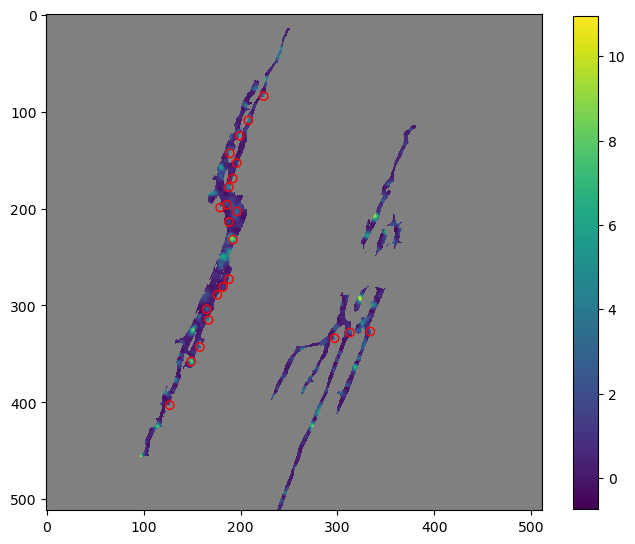

In [6]:
ind = 30   # choose a frame-index
image = cluster[ind]*mask

# Apply maximum filter to detect local maxima
filtered_image = maximum_filter(image, size=10)  # Adjust the size based on expected peak size
peaks = (image == filtered_image)  # Peaks are where the original image equals the maximum filter result

# Label the peaks
labeled_peaks, num_features = label(peaks)
# Mask NaN values to display them with a specific color
# masked_image = np.ma.masked_invalid(|image)

# Create a colormap that shows NaN values as a chosen color
cmap = plt.cm.viridis
cmap.set_bad(color='gray')  # Set the color for NaN values to a chosen color

# Plot the image and overlay the peaks
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(image, cmap=cmap, interpolation='nearest')
cbar = fig.colorbar(im, ax=ax, shrink = 0.8)   # Create a colorbar

# Mark the peaks with red dots
for i in range(1, num_features + 1):
    slice_y, slice_x = find_objects(labeled_peaks == i)[0]
    ax.scatter((slice_x.start + slice_x.stop - 1) / 2, (slice_y.start + slice_y.stop - 1) / 2, facecolor='none', color='r')

plt.show()
# Save as SVG with highest resolution
fig.savefig(data_folder+'\\peak_identification.svg', format='svg', bbox_inches='tight')

### Check threshold for a peak (we are using 1.0 by default)

In [7]:
yo = np.zeros((n_frames,1))
for i in tqdm(range(n_frames)):
    yo[i] = (np.nanpercentile(cluster[i]*mask,50))
print(f'Mean Value: {np.nanmean(yo):.2f}')

100%|██████████| 300/300 [00:00<00:00, 322.40it/s]

Mean Value: 0.81


## Peak Detection over time
### Extract the trajectories

In [8]:
# Parameters for particle detection
diameter = 5  # Approximate size of the particle in pixels
minmass = 1.0  # Minimum integrated brightness (mass) of a particle to be considered (we get an idea from the previous cell)
search_range = 5  # Maximum displacement between frames in pixels

# A list to store particle locations for each frame
particle_positions = []

# Loop through each 2D frame to detect particles
for t in tqdm(range(n_frames)):
    frame = np.nan_to_num(cluster[t] * mask, nan=0)  # Get the 2D frame from the 3D stack (apply mask if needed)
    # Detect particles with sub-pixel accuracy in this frame
    particles = tp.locate(frame, diameter=diameter, minmass=minmass, separation=15)
    
    # Add the frame number to each detected particle's data
    particles['frame'] = t
    
    # Store the detected particles
    particle_positions.append(particles)

# Combine all particle positions across frames into a single DataFrame
peaks_df = pd.concat(particle_positions)

# Use trackpy to link the particles over time
tp_trajectories = tp.link(peaks_df, search_range=search_range)

# Now tp_trajectories contains sub-pixel accurate positions and is linked over time
# print(tp_trajectories.head())

Frame 299: 51 trajectories present.


## Post-processing of the tracks:
### Step-i) Prunning out small tracks: We need a duration of atleast 3 timeframes
### Step-ii) Getting rid of the static and discontinuous tracks

In [111]:
# Filter out tracks with less than 3 frames
tp_trajectories_pruned = tp.filter_stubs(tp_trajectories, 3)  

movement_threshold = 3.0  # Adjust this threshold as needed
tp_trajectories_filtered = filter_tracks(tp_trajectories_pruned, movement_threshold)

# Calculate the duration of each track
track_duration = tp_trajectories_filtered.groupby('particle')['frame'].apply(lambda x: x.max() - x.min() + 1).reset_index(name='track_duration')
short_tracks = track_duration[track_duration['track_duration'] < 3]  # Filter tracks with less than 3 frames
print(short_tracks)   # Display tracks with less than 3 frames


Empty DataFrame
Columns: [particle, track_duration]
Index: []


### Visualizing the filtered tracks 

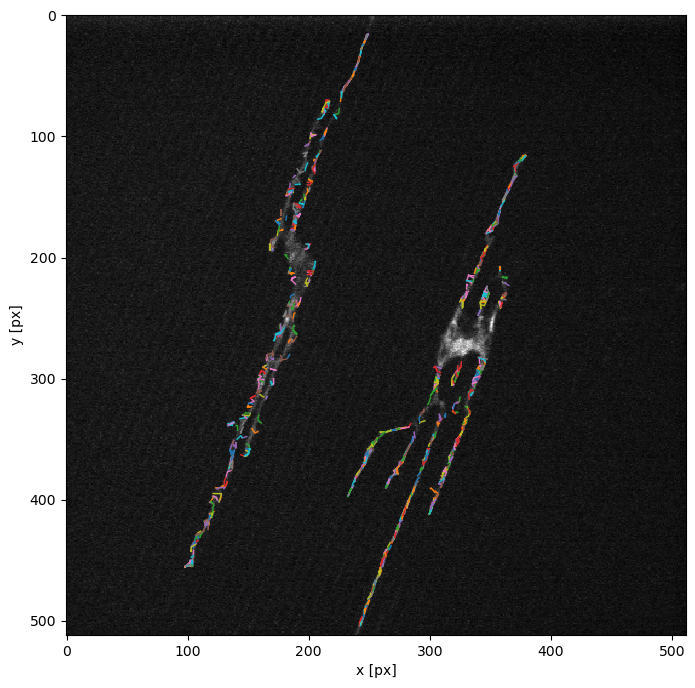

In [153]:
# Visualize the trajectories
fig, ax = plt.subplots(figsize = (8,12))  # Create a figure and axes
tp.plot_traj(tp_trajectories_filtered,superimpose=img[0],ax=ax)  # Pass the axes to the plot_traj function

ax.set_aspect('equal')  # Set equal axis scaling to ensure equal aspect ratio
plt.show()

# Save as SVG with highest resolution
fig.savefig(data_folder+'\\filtered_tracks.png', format='png', bbox_inches='tight', dpi = 600)

### Visualizing tracks as scatter points

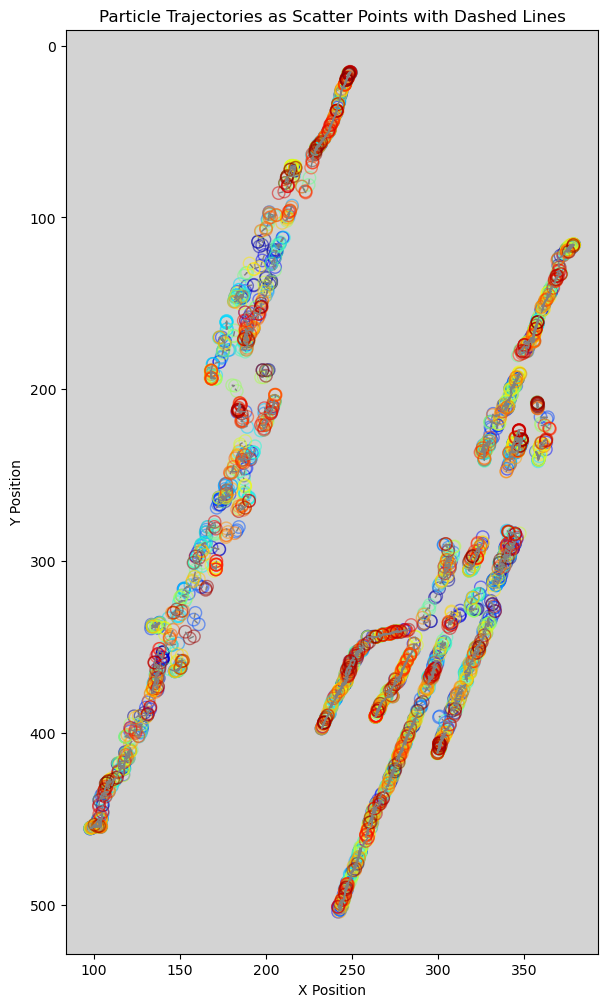

In [113]:
fig, ax = plt.subplots(figsize = (18,12))
colormap = cm.get_cmap('jet')

# Set figure background color to grey
ax.set_facecolor('lightgrey')  # Change to your preferred shade of grey

num_particles = tp_trajectories_filtered['particle'].nunique() # Determine the number of unique particles
colors = colormap(np.linspace(0, 1, num_particles))   # Create a list of colors from the colormap

# Create a color map for the particles
particle_color_map = dict(zip(tp_trajectories_filtered['particle'].unique(), colors))

# Group by particle ID to plot each track separately
for particle_id, track in tp_trajectories_filtered.groupby('particle'):

    # Get color for the current particle
    color = particle_color_map[particle_id]
    
    # Plot scatter points for each frame in the trajectory
    ax.scatter(track['x'], track['y'], s=80, facecolor='none', alpha=0.5, color=color)

    # Connect the points with a dashed line
    ax.plot(track['x'], track['y'], linestyle='--', linewidth=1, color='gray')

# Set axis labels and title
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Particle Trajectories as Scatter Points with Dashed Lines')

# Ensure equal axis scaling
ax.set_aspect('equal')
ax.invert_yaxis()

# Show the plot
plt.show()

# Save as SVG with highest resolution
fig.savefig(data_folder+'\\scatter_tracks.svg', format='svg', bbox_inches='tight')



## Track properties calculation (velocities, length, duration)

In [114]:
def calculate_track_metrics(tp_trajectories_filtered):
    """
    Calculate and store instantaneous frame-to-frame shifts (x, y, and frame), displacement, instantaneous velocity,
    total distance traversed, total displacement from initial position, total duration, average velocity of tracks,
    and the direction (angle) of track progression at each time step.

    Parameters:
    - tp_trajectories_filtered: pandas DataFrame, particle tracking data with 'x', 'y', 'frame', and 'particle' columns

    Returns:
    - tp_trajectories_filtered: pandas DataFrame, the original DataFrame with additional columns for the computed metrics
    
    The resulting DataFrame 'tp_trajectories_filtered' will contain the following columns:

    ### Instantaneous Calculations:
    1. **particle**: Unique identifier for each track (particle).
    2. **frame**: Time frame corresponding to the observation of a particle.
    3. **x**: x-coordinate of the particle in the given frame.
    4. **y**: y-coordinate of the particle in the given frame.
    5. **x_shift**: Frame-to-frame change in x-coordinate (`x[n] - x[n-1]`), filled with 0 for the first frame.
    6. **y_shift**: Frame-to-frame change in y-coordinate (`y[n] - y[n-1]`), filled with 0 for the first frame.
    7. **frame_shift**: Frame-to-frame difference in frame number, filled with 1 for the first frame.
    8. **displacement**: Euclidean distance between consecutive frames, representing instantaneous movement.
    9. **inst_velocity**: Instantaneous velocity, calculated as displacement divided by frame_shift.
    10. **angle**: The direction of movement (in radians), calculated using `arctan2(y_shift, x_shift)`.
    
    ### Track-Level Calculations:
    11. **track_length**: Total distance traveled by the particle over its entire track (sum of displacements).
    12. **track_duration**: Total number of unique frames in which the particle appears (duration of the track).
    13. **x_start**: x-coordinate of the particle at the start of the track.
    14. **y_start**: y-coordinate of the particle at the start of the track.
    15. **x_end**: x-coordinate of the particle at the end of the track.
    16. **y_end**: y-coordinate of the particle at the end of the track.
    17. **frame_start**: First frame in which the particle is observed.
    18. **frame_end**: Last frame in which the particle is observed.
    19. **distance**: Straight-line distance between the start and end positions of the particle.
    20. **avg_velocity**: Average velocity of the particle across its entire track, calculated as distance / track_duration.
    21. **avg_inst_velocity**: Average of the instantaneous velocities for each particle.
    """

    # 1. Calculate Instantaneous Shifts (x, y, and frame)
    tp_trajectories_filtered['x_shift'] = tp_trajectories_filtered.groupby('particle')['x'].diff()
    tp_trajectories_filtered['y_shift'] = tp_trajectories_filtered.groupby('particle')['y'].diff()
    tp_trajectories_filtered['frame_shift'] = tp_trajectories_filtered.groupby('particle')['frame'].diff()

    # Fill NaN values for the first frame of each track
    tp_trajectories_filtered['x_shift'] = tp_trajectories_filtered['x_shift'].fillna(0)
    tp_trajectories_filtered['y_shift'] = tp_trajectories_filtered['y_shift'].fillna(0)
    tp_trajectories_filtered['frame_shift'] = tp_trajectories_filtered['frame_shift'].fillna(1)  # Assume frame_shift is 1 for the first frame

    # 2. Calculate instantaneous displacement magnitude (distance per frame)
    tp_trajectories_filtered['displacement'] = np.sqrt(tp_trajectories_filtered['x_shift']**2 + tp_trajectories_filtered['y_shift']**2)

    # 3. Calculate instantaneous velocity magnitude (displacement per frame)
    tp_trajectories_filtered['inst_velocity'] = tp_trajectories_filtered['displacement'] / tp_trajectories_filtered['frame_shift']

    # Remove NaN values from displacement and velocity
    tp_trajectories_filtered = tp_trajectories_filtered.dropna(subset=['displacement', 'inst_velocity'])

    # 4. Calculate the Total Track Length (sum of displacements per particle)
    track_lengths = tp_trajectories_filtered.groupby('particle')['displacement'].sum().reset_index(name='track_length')

    # 5. Calculate the Track Duration (count of unique frames per particle)
    track_duration = tp_trajectories_filtered.groupby('particle')['frame'].nunique().reset_index(name='track_duration')

    # 6. Calculate start and end locations, and frames for each particle
    track_properties = tp_trajectories_filtered.groupby('particle').agg(
        x_start=('x', 'first'),
        y_start=('y', 'first'),
        x_end=('x', 'last'),
        y_end=('y', 'last'),
        frame_start=('frame', 'first'),
        frame_end=('frame', 'last')
    ).reset_index()

    # 7. Calculate the total displacement from initial to final position
    track_properties['distance'] = np.sqrt((track_properties['x_end'] - track_properties['x_start'])**2 +
                                           (track_properties['y_end'] - track_properties['y_start'])**2)

    # 8. Calculate average velocity (total displacement divided by track duration)
    track_properties['avg_velocity'] = track_properties['distance'] / track_duration['track_duration']

    # 9. Calculate the direction (angle) of movement at each time step
    # Negate y_shift to account for the image coordinate system
    tp_trajectories_filtered['angle'] = np.arctan2(-tp_trajectories_filtered['y_shift'], tp_trajectories_filtered['x_shift'])

    # Replace angles where there's no movement
    tp_trajectories_filtered['angle'] = np.where(
    (tp_trajectories_filtered['x_shift'] == 0) & (tp_trajectories_filtered['y_shift'] == 0), np.nan, 
        tp_trajectories_filtered['angle'])

    # 10. Calculate the average instantaneous velocity for each particle
    avg_inst_velocity = tp_trajectories_filtered.groupby('particle')['inst_velocity'].mean().reset_index(name='avg_inst_velocity')

    # Merge the calculated average instantaneous velocity back into the main DataFrame
    tp_trajectories_filtered = pd.merge(tp_trajectories_filtered, avg_inst_velocity, on='particle')

    # 11. Merge the calculated properties back into the original dataframe
    track_properties = pd.merge(track_properties, track_lengths, on='particle')
    track_properties = pd.merge(track_properties, track_duration, on='particle')

    # Optionally merge track_properties back with the original dataframe if you want to keep all the data
    tp_trajectories_filtered = pd.merge(tp_trajectories_filtered, track_properties, on='particle')

    return tp_trajectories_filtered

tp_trajectories_final = calculate_track_metrics(tp_trajectories_filtered)

## Plotting the distributions
### Track duration distribution (s)

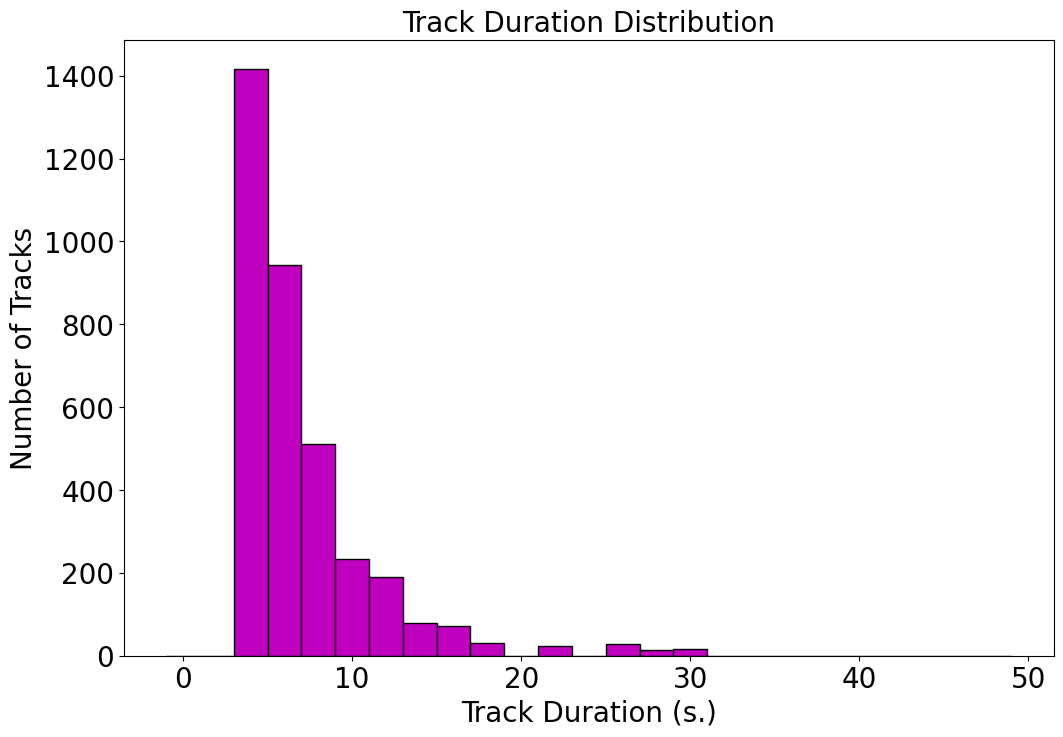

In [115]:
# Plot Track Duration Distribution
fig, ax = plt.subplots(figsize = (12,8))

plt.hist(tp_trajectories_final['track_duration']*frame_interval, bins=np.arange(0,51,2), color='m', edgecolor='k', align='left')
plt.title('Track Duration Distribution', fontsize=20)
plt.xlabel('Track Duration (s.)', fontsize=20)
plt.ylabel('Number of Tracks', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(False)
plt.show()
# Save as SVG with highest resolution
fig.savefig(data_folder+'\\track_durations.svg', format='svg', bbox_inches='tight')


### Track total distance traversed distribution (um.)

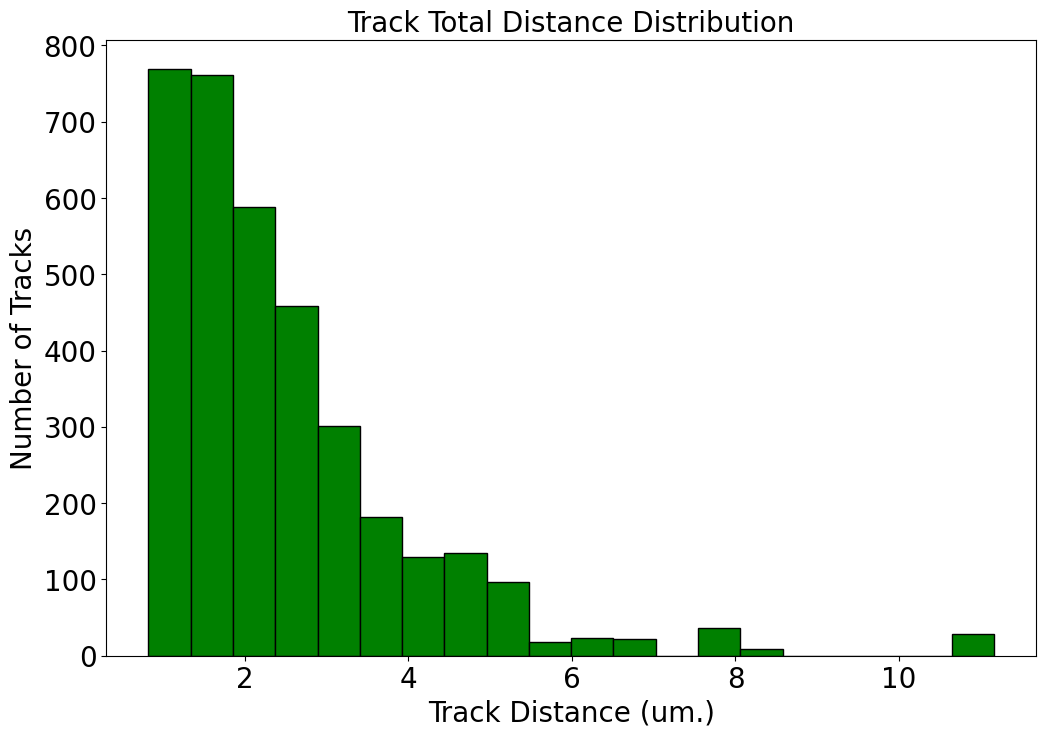

In [116]:
# Plot Track Duration Distribution
fig, ax = plt.subplots(figsize = (12,8))

plt.hist(tp_trajectories_final['track_length']/resolution, bins=20, color='g', edgecolor='k', align='left')
plt.title('Track Total Distance Distribution', fontsize=20)
plt.xlabel('Track Distance (um.)', fontsize=20)
plt.ylabel('Number of Tracks', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(False)
plt.show()
# Save as SVG with highest resolution
fig.savefig(data_folder+'\\track_total_distance.svg', format='svg', bbox_inches='tight')

### Track final position distance distribution (um.)

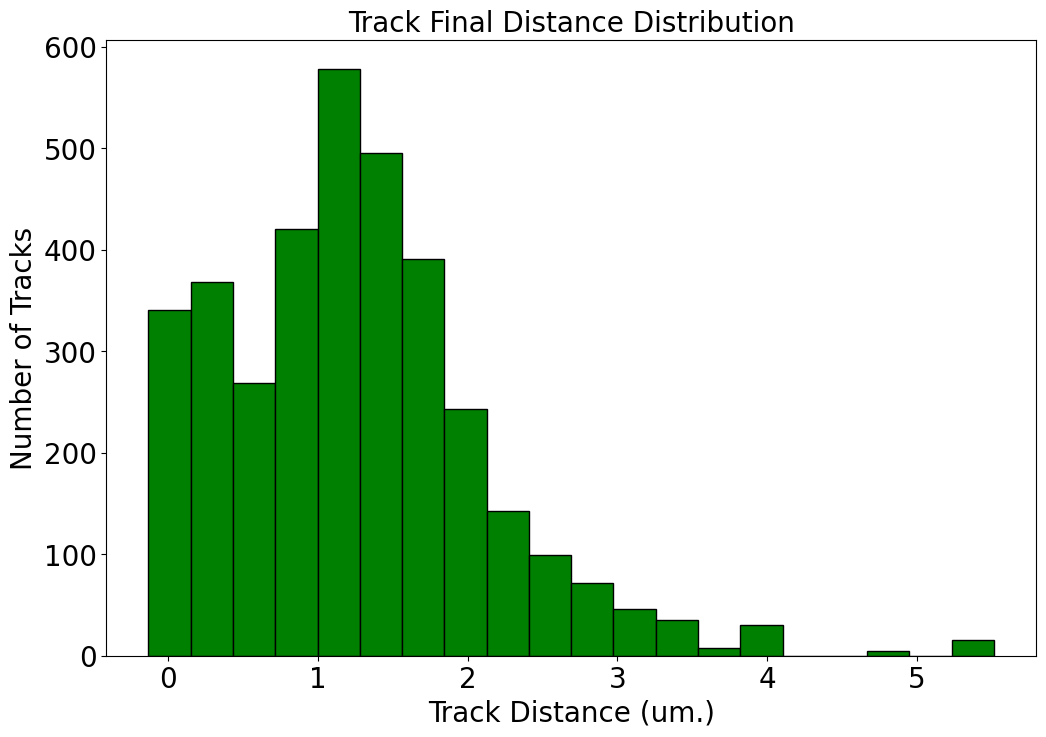

In [117]:
# Plot Track Duration Distribution
fig, ax = plt.subplots(figsize = (12,8))

plt.hist(tp_trajectories_final['distance']/resolution, bins=20, color='g', edgecolor='k', align='left')
plt.title('Track Final Distance Distribution', fontsize=20)
plt.xlabel('Track Distance (um.)', fontsize=20)
plt.ylabel('Number of Tracks', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(False)
plt.show()
# Save as SVG with highest resolution
fig.savefig(data_folder+'\\track_final_distance.svg', format='svg', bbox_inches='tight')

### Track velocities distribution (#um./min)

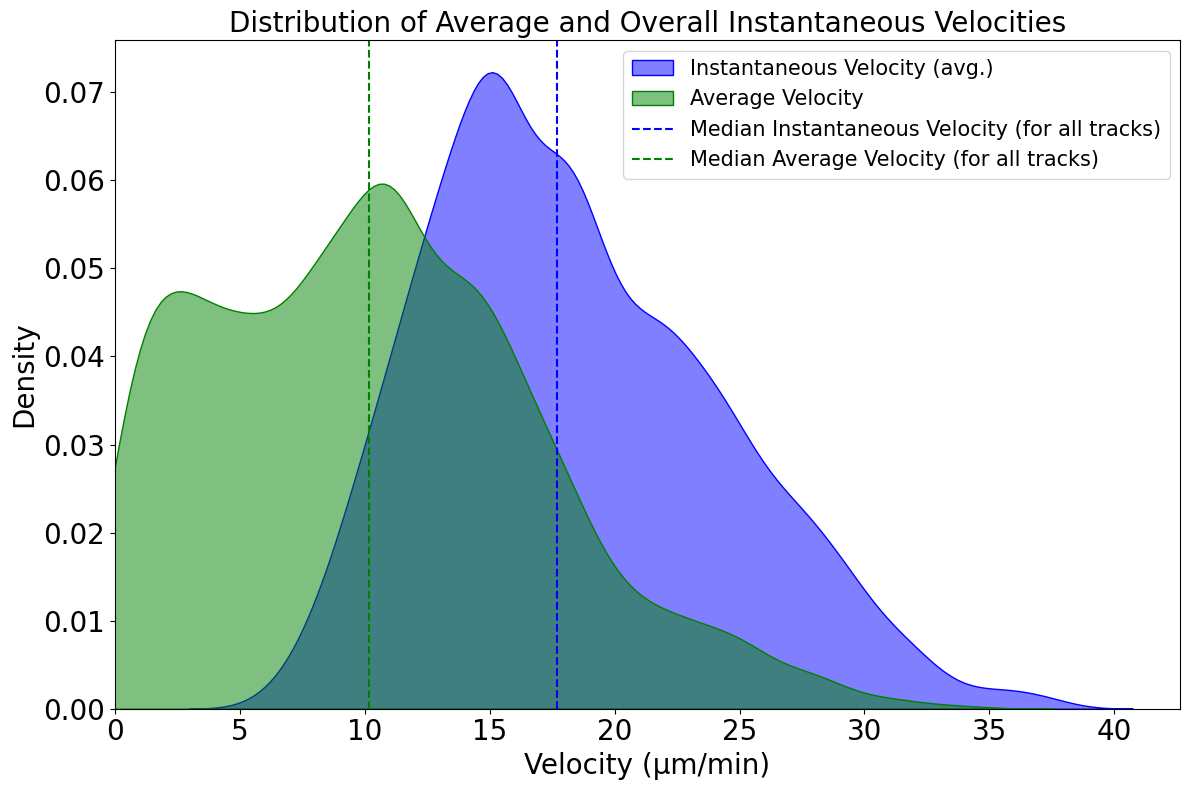

In [118]:
# Set up the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot average instantaneous velocity distribution
sns.kdeplot(tp_trajectories_final['avg_inst_velocity'] * 60 / (resolution * frame_interval),
            label='Instantaneous Velocity (avg.)', color='blue', fill=True, alpha=0.5).set(xlim=(0))

# Plot for overall average velocities
sns.kdeplot(tp_trajectories_final['avg_velocity'] * 60 / (resolution * frame_interval),
            label='Average Velocity', color='green', fill=True, alpha=0.5).set(xlim=(0))

# Add vertical lines for medians
plt.axvline(np.median(tp_trajectories_final['avg_inst_velocity']) * 60 / (resolution * frame_interval),
            color='blue', linestyle='--', label='Median Instantaneous Velocity (for all tracks)')
plt.axvline(np.median(tp_trajectories_final['avg_velocity']) * 60 / (resolution * frame_interval),
            color='green', linestyle='--', label='Median Average Velocity (for all tracks)')

# Set x-axis limits and labels
plt.xlim(0, )  # Only set x limit
plt.xlabel('Velocity (μm/min)', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.title('Distribution of Average and Overall Instantaneous Velocities', fontsize=20)

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)

# Add legend
plt.legend(fontsize=15)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(os.path.join(data_folder, 'track_velocities.svg'), format='svg', bbox_inches='tight')


### Plot angular orientation of the tracks (at all timeframes)

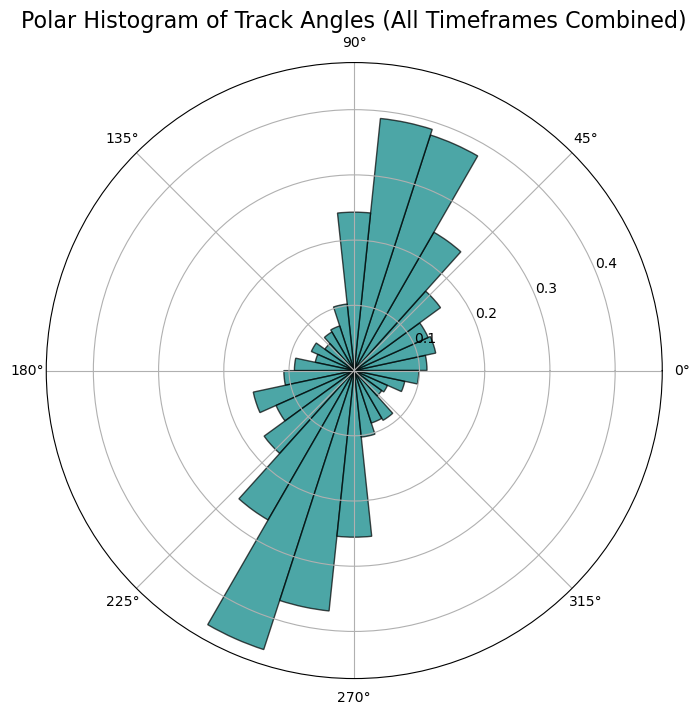

In [119]:
# Assuming `tp_trajectories_filtered` contains the 'angle' column from the previous calculations

# Remove NaN values from the 'angle' column to ensure we don't plot them as zero
valid_angles = tp_trajectories_final['angle'].dropna()

# Convert the valid angles to be in the range [0, 2*pi]
all_angles = np.mod(valid_angles, 2 * np.pi)

# Set up the polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))

# Plot polar histogram of all valid angles
ax.hist(all_angles, bins=30, color='teal', alpha=0.7, edgecolor='black', density=True)

# Add title and labels
ax.set_title('Polar Histogram of Track Angles (All Timeframes Combined)', fontsize=16)

# Show the plot
plt.show()

# Save the figure
fig.savefig(os.path.join(data_folder, 'track_angles_polar_histogram.svg'), format='svg', bbox_inches='tight')


In [86]:
# Custom function to merge opposite angles
def merge_opposite_angles(angles):
    # Map angles to their nearest equivalent in the range [0, pi]
    adjusted_angles = np.where(angles > np.pi, angles - 2 * np.pi, angles)
    return adjusted_angles

### See how the angular distribution changes with varying track_length threshold

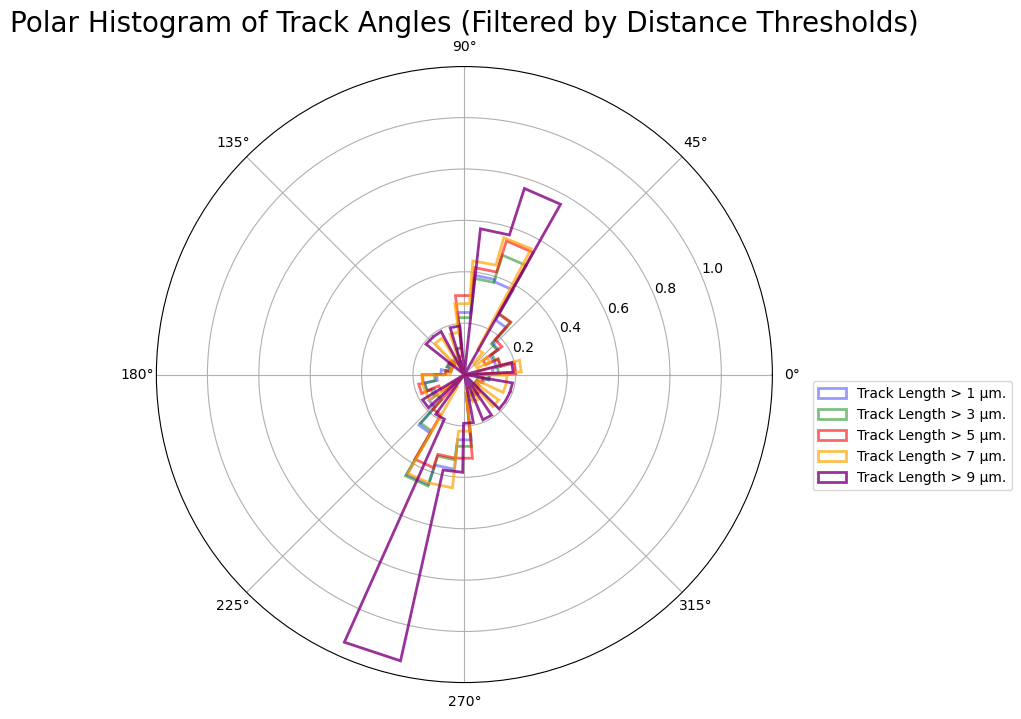

In [120]:
# Define the track length thresholds to be tested
track_length_thresholds = np.array([1, 3, 5, 7, 9])  # You can modify these values

# Set up the figure and polar axis
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Color map for different thresholds
colors = ['blue', 'green', 'red', 'orange', 'purple']

# Store Chi-squared statistics and Rayleigh statistics for each threshold
chi_squared_stats = []
rayleigh_stats = []

# Plot the histograms for each threshold
for i, threshold in enumerate(track_length_thresholds):
    # Filter angles based on the current track length threshold
    angle_condition = tp_trajectories_final['track_length']/resolution  > threshold
    filtered_angles = tp_trajectories_final.loc[angle_condition, 'angle'].dropna()  # Remove NaN values

    # Applying the function to your filtered angles
    filtered_angles_adjusted = merge_opposite_angles(filtered_angles)
    # Continue with the Rayleigh test or Chi-squared test on adjusted angles

    # Check if filtered_angles is not empty
    if len(filtered_angles_adjusted) > 0:               
        # Plot the polar histogram with varying transparencies
        counts, bins = np.histogram(np.mod(filtered_angles_adjusted, 2 * np.pi), bins=30, density=True)
        ax.hist(bins[:-1], bins=bins, weights=counts, histtype='step', 
                alpha=0.4 + 0.1 * i, color=colors[i], linewidth=2, 
                label=f'Track Length > {threshold} μm.')

        # Calculate the expected frequencies for a uniform distribution
        expected_counts = np.ones_like(counts) * (sum(counts) / len(counts))

        # Compute the Chi-squared statistic
        chi_squared = np.sum((counts - expected_counts) ** 2 / expected_counts)
        chi_squared_stats.append(chi_squared)

        # Rayleigh Test for circular data
        n = len(filtered_angles)
        R = np.sum(np.cos(filtered_angles_adjusted))**2 + np.sum(np.sin(filtered_angles_adjusted))**2
        R /= n  # Normalize
        rayleigh_stat = n * R  # Rayleigh statistic
        
        # Calculate the p-value
        if rayleigh_stat > 0:
            p_value = np.exp(-rayleigh_stat)  # p-value for Rayleigh test
        else:
            p_value = 1.0

        rayleigh_stats.append((rayleigh_stat, p_value))
    else:
        print(f'No valid angles found for Track Length > {threshold}')

# Set labels and title
ax.set_title('Polar Histogram of Track Angles (Filtered by Distance Thresholds)', fontsize=20)

# Add legend to differentiate thresholds
ax.legend(loc='best', bbox_to_anchor=( 1.4, 0.5))

# Show the plot
plt.show()

# Optionally, save the plot
fig.savefig(os.path.join(data_folder, 'track_angles_polar_histogram_thresholds.svg'), format='svg', bbox_inches='tight')

# # Print Chi-squared statistics and Rayleigh test results
# for i, threshold in enumerate(track_length_thresholds):
#     print(f'Chi-squared statistic for Track Length > {threshold}: {chi_squared_stats[i] if i < len(chi_squared_stats) else "N/A"}')
#     if i < len(rayleigh_stats):
#         rayleigh_stat, p_value = rayleigh_stats[i]
#         print(f'Rayleigh statistic for Track Length > {threshold}: {rayleigh_stat:.4f}, p-value: {p_value:.4f}')
#     else:
#         print(f'Rayleigh statistic for Track Length > {threshold}: N/A')


### Plot angular orientation of the tracks wrt the nanoridges

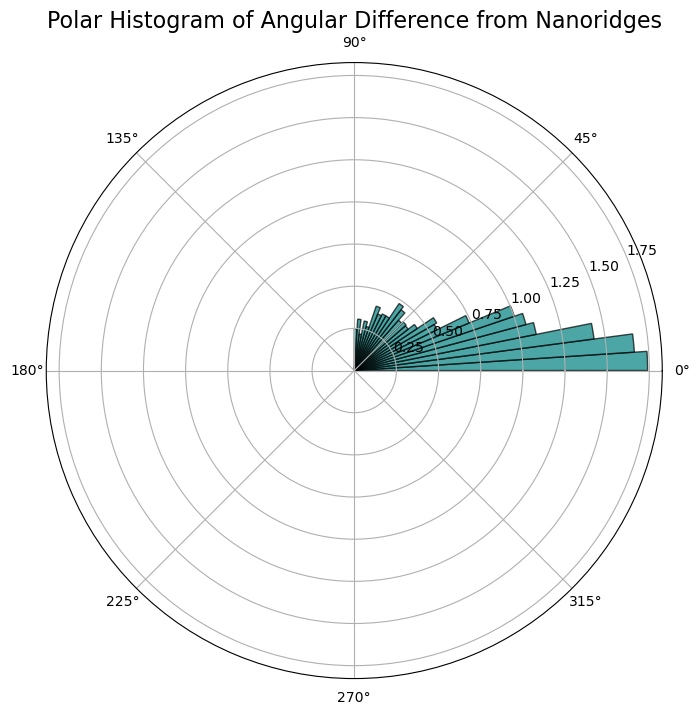

In [144]:
# Load the reference orientation from the .mat file
mat_file = data_folder + '\\skeleton_orientation.mat'
data = sio.loadmat(mat_file)
angle_deg = data['angle_deg'].squeeze()  # Load and squeeze to get the array

# Convert angle_deg to radians (since it's given in degrees)
reference_angle = np.deg2rad(angle_deg)

# Assuming `tp_trajectories_final` contains the 'angle' column with angles in radians
# Remove NaN values from the 'angle' column to ensure we don't plot them as zero
valid_angles = tp_trajectories_final['angle'].dropna()

# Convert valid angles to the range [0, 2*pi] if needed
all_angles = np.mod(valid_angles, 2 * np.pi)

# Compute the absolute angular difference with respect to the reference orientation
angular_diff = np.abs(all_angles - reference_angle)

# Normalize the angular difference to the range [0, π]
angular_diff = np.mod(angular_diff, np.pi)

# Collapse angles to the range [0, π/2] by adjusting values greater than π/2
angular_diff = np.where(angular_diff > np.pi / 2, np.pi - angular_diff, angular_diff)

# Set up the polar plot for angular differences
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))

# Plot polar histogram of the angular differences
ax.hist(angular_diff, bins=24, color='teal', alpha=0.7, edgecolor='black', density=True)

# Add title and labels
ax.set_title('Polar Histogram of Angular Difference from Nanoridges', fontsize=16)

# Show the plot
plt.show()

# Save the figure
fig.savefig(data_folder + '\\angular_diff_wrt_nanoridges.svg', format='svg', bbox_inches='tight')


### Plot the orientations with varying track length thresholds

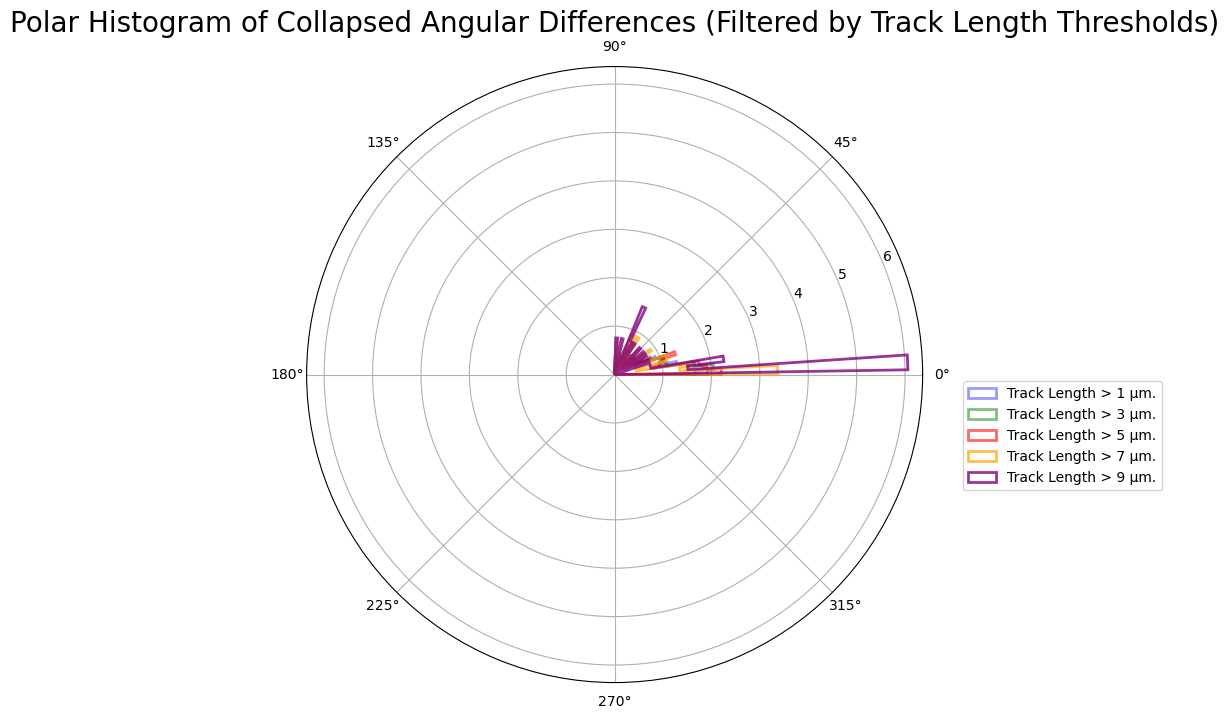

In [147]:
# Load the reference orientation from the .mat file
mat_file = data_folder + '\\skeleton_orientation.mat'
data = sio.loadmat(mat_file)
angle_deg = data['angle_deg'].squeeze()  # Load and squeeze to get the array

# Convert angle_deg to radians (since it's given in degrees)
reference_angle = np.deg2rad(angle_deg)

# Define the track length thresholds to be tested
track_length_thresholds = np.array([1, 3, 5, 7, 9])  # Modify these values as needed

# Set up the figure and polar axis
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Color map for different thresholds
colors = ['blue', 'green', 'red', 'orange', 'purple']

# Plot the histograms for each threshold
for i, threshold in enumerate(track_length_thresholds):
    # Filter angles based on the current track length threshold
    angle_condition = tp_trajectories_final['track_length'] / resolution > threshold
    filtered_angles = tp_trajectories_final.loc[angle_condition, 'angle'].dropna()  # Remove NaN values

    # Compute angular differences with respect to the reference orientation
    angular_diff = np.abs(filtered_angles - reference_angle)  # Angular difference in radians

    # Collapse the angular difference to the range [0, pi/2]
    angular_diff = np.mod(angular_diff, np.pi)  # Normalize to [0, pi]
    angular_diff = np.where(angular_diff > np.pi / 2, np.pi - angular_diff, angular_diff)  # Collapse to [0, pi/2]

    # Check if filtered_angles is not empty
    if len(angular_diff) > 0:
        # Plot the polar histogram with varying transparencies
        counts, bins = np.histogram(angular_diff, bins=30, density=True)
        ax.hist(bins[:-1], bins=bins, weights=counts, histtype='step', 
                alpha=0.4 + 0.1 * i, color=colors[i], linewidth=2, 
                label=f'Track Length > {threshold} μm.')

    else:
        print(f'No valid angles found for Track Length > {threshold}')

# Set labels and title
ax.set_title('Polar Histogram of Collapsed Angular Differences (Filtered by Track Length Thresholds)', fontsize=20)

# Add legend to differentiate thresholds
ax.legend(loc='best', bbox_to_anchor=(1.4, 0.5))

# Show the plot
plt.show()

# Optionally, save the plot
fig.savefig(os.path.join(data_folder, 'angular_diff_nanoridges_thresholds.svg'), format='svg', bbox_inches='tight')


In [71]:
print(f'Number of unique tracks: {num_particles:.2f}')
tp_trajectories_final

Number of unique tracks: 588.00


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,...,x_start,y_start,x_end,y_end,frame_start,frame_end,distance,avg_velocity,track_length,track_duration
0,422.942928,114.255583,9.776421,1.345888,0.133064,1.285733,86.379686,0.001283,0,16,...,114.255583,422.942928,117.870416,415.955990,0,2,7.866658,2.622219,8.005550,3
1,134.782328,200.042026,22.512454,1.256449,0.059918,3.444794,153.834008,0.000720,0,30,...,200.042026,134.782328,202.038298,139.025532,0,2,4.689337,1.563112,5.585405,3
2,295.979769,341.884393,8.393652,1.286884,0.037315,1.212956,59.062037,0.001876,0,40,...,341.884393,295.979769,339.816964,300.883929,0,3,5.322128,1.330532,11.446906,4
3,418.885563,117.163732,5.654452,1.317541,0.096779,0.766537,39.785126,0.001525,1,16,...,114.255583,422.942928,117.870416,415.955990,0,2,7.866658,2.622219,8.005550,3
4,297.087649,338.100598,9.994841,1.285453,0.146207,1.463388,91.279306,0.000665,1,40,...,341.884393,295.979769,339.816964,300.883929,0,3,5.322128,1.330532,11.446906,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2524,428.009585,108.025559,10.592234,1.140316,0.363119,1.827414,62.340811,0.003567,299,8843,...,113.284091,426.045455,108.025559,428.009585,295,299,5.613374,1.122675,9.199002,5
2525,207.615635,357.944625,10.389188,1.060084,0.271618,2.233506,42.648096,0.005215,299,8823,...,358.174242,209.136364,357.944625,207.615635,294,299,1.537966,0.256328,5.305392,6
2526,19.914414,246.653153,7.512703,1.252025,0.149381,1.218276,40.228941,0.005528,299,8850,...,246.986111,19.114379,246.653153,19.914414,295,299,0.866555,0.173311,7.786159,5
2527,71.088285,217.188455,19.932350,1.283961,0.043420,2.910326,132.472648,0.001679,299,8851,...,211.953431,76.949755,217.188455,71.088285,295,299,7.858899,1.571780,14.708525,5


In [121]:
# Save DataFrame to CSV
save_path = data_folder+'\\'
tp_trajectories_final.to_csv(save_path+'tp_trajectories_final.csv', index=False)


### What's the 1px/frame speed equivalent in #um./min

In [122]:
60/(resolution*frame_interval)

10.80088568040243